# **This Looks Like That: Deep Learning for Interpretable Image Recognition**

## Environment Setup

In [1]:
# Install dependencies
!pip install torch torchvision torchaudio --quiet
!pip install seaborn scikit-learn kaggle --quiet

import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Set global plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
!git clone https://github.com/rankovicandjela/ProtoPNet.git
%cd ProtoPNet

Cloning into 'ProtoPNet'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (14/14), done.


## Download CUB-200-2011 Dataset Automatically

In [ ]:
# Install kagglehub if not already installed
!pip install kagglehub --quiet

import kagglehub

# Download latest version of dataset
path = kagglehub.dataset_download("wenewone/cub2002011")
print("Dataset downloaded to:", path)

# Set path to the images folder
data_dir = path + "/CUB_200_2011/images"
print("Images directory:", data_dir)

100%|██████████| 1.49G/1.49G [00:12<00:00, 125MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/wenewone/cub2002011/versions/7
Images directory: /root/.cache/kagglehub/datasets/wenewone/cub2002011/versions/7/CUB_200_2011/images


## Preparing the Data

### Crop Images Using Bounding Boxes

In [ ]:
import os
import pandas as pd
from PIL import Image

# Define base dataset paths
base_dir = os.path.join(path, "CUB_200_2011")
images_dir = os.path.join(base_dir, "images")
bbox_file = os.path.join(base_dir, "bounding_boxes.txt")
images_file = os.path.join(base_dir, "images.txt")

# Save cropped images to a writable location
crop_dir = "/content/ProtoPNet/datasets/cub200_cropped"
os.makedirs(crop_dir, exist_ok=True)

# Load bounding boxes + image paths
bbox_df = pd.read_csv(bbox_file, sep=" ", header=None,
                      names=["img_id", "x", "y", "width", "height"])
images_df = pd.read_csv(images_file, sep=" ", header=None,
                        names=["img_id", "rel_path"])
df = pd.merge(bbox_df, images_df, on="img_id")

# Crop images and save them to the writable directory
for _, row in df.iterrows():
    img_path = os.path.join(images_dir, row["rel_path"])
    save_path = os.path.join(crop_dir, row["rel_path"])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    with Image.open(img_path) as img:
        x, y = int(row["x"]), int(row["y"])
        w, h = int(row["width"]), int(row["height"])
        cropped = img.crop((x, y, x + w, y + h))
        cropped.save(save_path)

print(f"Cropped images saved to: {crop_dir}")

Cropped images saved to: /content/ProtoPNet/datasets/cub200_cropped


### Visualize Before vs After Cropping

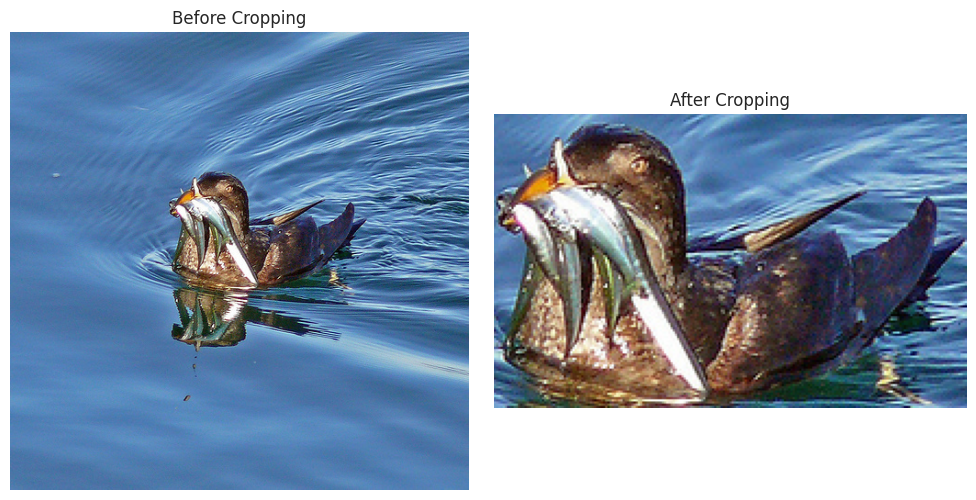

In [ ]:
import matplotlib.pyplot as plt
import os
import random

# Load bounding boxes + image paths
bbox_df = pd.read_csv(bbox_file, sep=" ", header=None, names=["img_id", "x", "y", "width", "height"])
images_df = pd.read_csv(images_file, sep=" ", header=None, names=["img_id", "rel_path"])
df = pd.merge(bbox_df, images_df, on="img_id")

# Pick one random image
row = df.sample(1, random_state=random.randint(0, len(df)-1)).iloc[0]

# Paths and bounding box
img_path = os.path.join(images_dir, row["rel_path"])
x, y, w, h = int(row["x"]), int(row["y"]), int(row["width"]), int(row["height"])

# Open original and cropped image
img = Image.open(img_path)
cropped = img.crop((x, y, x + w, y + h))

# Show side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title("Before Cropping", fontsize=12)
axes[0].axis("off")

axes[1].imshow(cropped)
axes[1].set_title("After Cropping", fontsize=12)
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Split Cropped Dataset into Train/Test Folders

The CUB-200-2011 dataset contains 11,788 images of 200 bird species and follows an official train-test split defined in the provided `train_test_split.txt` file. Each image is annotated as either belonging to the training or testing set, and this split is fixed to ensure consistency across studies using the dataset. Following the official configuration, the cropped images are organized into two separate directories: train_cropped and test_cropped. No additional manual splitting was performed, as keeping the predefined split is essential for fair comparison with existing approaches and for reproducibility of results.

In [ ]:
import shutil

split_file = os.path.join(base_dir, "train_test_split.txt")
split_df = pd.read_csv(split_file, sep=" ", header=None, names=["img_id", "is_train"])
df = pd.merge(split_df, images_df, on="img_id")

# Final dataset paths
datasets_root = crop_dir
train_dir = os.path.join(datasets_root, "train_cropped")
test_dir = os.path.join(datasets_root, "test_cropped")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move images
for _, row in df.iterrows():
    src = os.path.join(crop_dir, row["rel_path"])
    dst_root = train_dir if row["is_train"] == 1 else test_dir
    dst = os.path.join(dst_root, row["rel_path"])
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.move(src, dst)
    if os.path.exists(src):
        os.remove(src)
    src_parent = os.path.dirname(src)
    try:
        os.removedirs(src_parent)
    except OSError:
        # This occurs if the directory is not empty, so we skip it
        pass

print("Cropped dataset organized into:")
print(f"Train: {train_dir}")
print(f"Test:  {test_dir}")

Cropped dataset organized into:
Train: /content/ProtoPNet/datasets/cub200_cropped/train_cropped
Test:  /content/ProtoPNet/datasets/cub200_cropped/test_cropped


In [ ]:
from collections import Counter

# === 2. Count images per class (after splitting) ===
def count_images_per_class(directory):
    return Counter([
        folder for folder in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, folder))
    ])

train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in os.listdir(test_dir)}

# Compute total images per class (train + test)
total_counts = Counter({
    cls: train_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in set(train_counts) | set(test_counts)
})

# === 3. Select top 10 classes ===
top_10_classes = {cls for cls, _ in total_counts.most_common(10)}
print("Top 10 classes to keep:")
for cls in top_10_classes:
    print(f"  {cls}: train={train_counts.get(cls, 0)}, test={test_counts.get(cls, 0)}")

# === 4. Remove all other classes ===
def keep_only_top_classes(base_path, top_classes):
    for cls in os.listdir(base_path):
        cls_path = os.path.join(base_path, cls)
        if os.path.isdir(cls_path) and cls not in top_classes:
            shutil.rmtree(cls_path)

keep_only_top_classes(train_dir, top_10_classes)
keep_only_top_classes(test_dir, top_10_classes)

print("\nFinal dataset created:")
print(f"Train images → {train_dir}")
print(f"Test images  → {test_dir}")

Top 10 classes to keep:
  123.Henslow_Sparrow: train=30, test=30
  104.American_Pipit: train=30, test=30
  031.Black_billed_Cuckoo: train=30, test=30
  010.Red_winged_Blackbird: train=30, test=30
  029.American_Crow: train=30, test=30
  133.White_throated_Sparrow: train=30, test=30
  163.Cape_May_Warbler: train=30, test=30
  057.Rose_breasted_Grosbeak: train=30, test=30
  116.Chipping_Sparrow: train=30, test=30
  175.Pine_Warbler: train=30, test=30

Final dataset created:
Train images → /content/ProtoPNet/datasets/cub200_cropped/train_cropped
Test images  → /content/ProtoPNet/datasets/cub200_cropped/test_cropped


In [ ]:
!ls /content/ProtoPNet/datasets

cub200_cropped


In [ ]:
!ls /content/ProtoPNet/datasets/cub200_cropped

test_cropped  train_cropped


In [ ]:
%cd /content/ProtoPNet

/content/ProtoPNet


In [ ]:
!pip install Augmentor --quiet
import Augmentor
import os
def makedir(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

datasets_root_dir = './datasets/cub200_cropped/'
dir = datasets_root_dir + 'train_cropped/'
target_dir = '../../train_cropped_augmented/'

makedir('./datasets/cub200_cropped/train_cropped_augmented/')
folders = [os.path.join(dir, folder) for folder in next(os.walk(dir))[1]]
target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(dir))[1]]
for i in range(len(folders)):
    fd = folders[i]
    tfd = target_folders[i]
    # rotation
    marker_path = os.path.join(fd,tfd)

    # Skip if already augmented
    if os.path.exists(marker_path):
        print(f"Skipping {fd} -> {tfd} (augmentation already done)")
        continue

    print(f"Augmenting: {fd} -> {tfd}")
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p
    # skew
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.skew(probability=1, magnitude=0.2)  # max 45 degrees
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p
    # shear
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.shear(probability=1, max_shear_left=10, max_shear_right=10)
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p

Augmenting: ./datasets/cub200_cropped/train_cropped/123.Henslow_Sparrow -> ../../train_cropped_augmented/123.Henslow_Sparrow
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/123.Henslow_Sparrow/../../train_cropped_augmented/123.Henslow_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0906FC0>: 100%|██████████| 30/30 [00:00<00:00, 144.25 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BBB272CEFC0>: 100%|██████████| 30/30 [00:00<00:00, 125.05 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F09012E0>: 100%|██████████| 30/30 [00:00<00:00, 137.50 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD751AF0>: 100%|██████████| 30/30 [00:00<00:00, 140.31 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0907B60>: 100%|██████████| 30/30 [00:00<00:00, 132.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0901AF0>: 100%|██████████| 30/30 [00:00<00:00, 132.65 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0905280>: 100%|██████████| 30/30 [00:00<00:00, 94.72 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD585BB0>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/123.Henslow_Sparrow/../../train_cropped_augmented/123.Henslow_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD587C50>: 100%|██████████| 30/30 [00:00<00:00, 87.51 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD586210>: 100%|██████████| 30/30 [00:00<00:00, 104.18 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD585340>: 100%|██████████| 30/30 [00:00<00:00, 93.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD586AB0>: 100%|██████████| 30/30 [00:00<00:00, 103.24 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0905B80>: 100%|██████████| 30/30 [00:00<00:00, 95.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FC0FFBC0>: 100%|██████████| 30/30 [00:00<00:00, 152.30 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD70D5E0>: 100%|██████████| 30/30 [00:00<00:00, 137.63 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FC0FEB40>: 100%|█████

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/123.Henslow_Sparrow/../../train_cropped_augmented/123.Henslow_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD72BC50>: 100%|██████████| 30/30 [00:00<00:00, 147.89 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD585E80>: 100%|██████████| 30/30 [00:00<00:00, 134.90 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0907FE0>: 100%|██████████| 30/30 [00:00<00:00, 141.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0902210>: 100%|██████████| 30/30 [00:00<00:00, 148.38 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FFD37860>: 100%|██████████| 30/30 [00:00<00:00, 145.09 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F09063C0>: 100%|██████████| 30/30 [00:00<00:00, 143.61 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9FD586FC0>: 100%|██████████| 30/30 [00:00<00:00, 132.06 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=303x272 at 0x7BB9F0906E40>: 100%|██

Augmenting: ./datasets/cub200_cropped/train_cropped/010.Red_winged_Blackbird -> ../../train_cropped_augmented/010.Red_winged_Blackbird
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/010.Red_winged_Blackbird/../../train_cropped_augmented/010.Red_winged_Blackbird.

Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0900C20>: 100%|██████████| 30/30 [00:00<00:00, 140.90 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0906900>: 100%|██████████| 30/30 [00:00<00:00, 122.85 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD585BB0>: 100%|██████████| 30/30 [00:00<00:00, 141.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0907CE0>: 100%|██████████| 30/30 [00:00<00:00, 134.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD587380>: 100%|██████████| 30/30 [00:00<00:00, 144.33 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD5862D0>: 100%|██████████| 30/30 [00:00<00:00, 154.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0905B50>: 100%|██████████| 30/30 [00:00<00:00, 129.89 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD587BF0>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/010.Red_winged_Blackbird/../../train_cropped_augmented/010.Red_winged_Blackbird.

Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0905A90>: 100%|██████████| 30/30 [00:00<00:00, 148.43 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FC8BC740>: 100%|██████████| 30/30 [00:00<00:00, 147.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0905910>: 100%|██████████| 30/30 [00:00<00:00, 151.04 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD585910>: 100%|██████████| 30/30 [00:00<00:00, 155.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0902210>: 100%|██████████| 30/30 [00:00<00:00, 153.20 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD5868D0>: 100%|██████████| 30/30 [00:00<00:00, 143.10 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0905730>: 100%|██████████| 30/30 [00:00<00:00, 140.97 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD586BD0>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/010.Red_winged_Blackbird/../../train_cropped_augmented/010.Red_winged_Blackbird.

Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0906630>: 100%|██████████| 30/30 [00:00<00:00, 147.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BBA00477CB0>: 100%|██████████| 30/30 [00:00<00:00, 135.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0906E70>: 100%|██████████| 30/30 [00:00<00:00, 145.09 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0901FD0>: 100%|██████████| 30/30 [00:00<00:00, 150.06 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FD70FB90>: 100%|██████████| 30/30 [00:00<00:00, 145.51 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F09056D0>: 100%|██████████| 30/30 [00:00<00:00, 148.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9F0906A80>: 100%|██████████| 30/30 [00:00<00:00, 134.65 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=398x221 at 0x7BB9FFCCEE70>: 100%|██

Augmenting: ./datasets/cub200_cropped/train_cropped/104.American_Pipit -> ../../train_cropped_augmented/104.American_Pipit
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/104.American_Pipit/../../train_cropped_augmented/104.American_Pipit.

Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD70D430>: 100%|██████████| 30/30 [00:00<00:00, 150.24 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F0902210>: 100%|██████████| 30/30 [00:00<00:00, 142.07 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F0906A80>: 100%|██████████| 30/30 [00:00<00:00, 118.67 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD597BC0>: 100%|██████████| 30/30 [00:00<00:00, 98.89 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD587D10>: 100%|██████████| 30/30 [00:00<00:00, 110.26 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD5869C0>: 100%|██████████| 30/30 [00:00<00:00, 97.09 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD586120>: 100%|██████████| 30/30 [00:00<00:00, 98.30 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F09063F0>: 100%|█████

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/104.American_Pipit/../../train_cropped_augmented/104.American_Pipit.

Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD586900>: 100%|██████████| 30/30 [00:00<00:00, 105.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FC8BD9A0>: 100%|██████████| 30/30 [00:00<00:00, 109.76 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F09053D0>: 100%|██████████| 30/30 [00:00<00:00, 99.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F0905610>: 100%|██████████| 30/30 [00:00<00:00, 137.13 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F0907350>: 100%|██████████| 30/30 [00:00<00:00, 164.79 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD586FC0>: 100%|██████████| 30/30 [00:00<00:00, 163.04 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD5858B0>: 100%|██████████| 30/30 [00:00<00:00, 167.97 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD586900>: 100%|███

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/104.American_Pipit/../../train_cropped_augmented/104.American_Pipit.

Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD586A80>: 100%|██████████| 30/30 [00:00<00:00, 157.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD586C60>: 100%|██████████| 30/30 [00:00<00:00, 158.02 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F0905100>: 100%|██████████| 30/30 [00:00<00:00, 160.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD5869C0>: 100%|██████████| 30/30 [00:00<00:00, 139.79 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD585AF0>: 100%|██████████| 30/30 [00:00<00:00, 158.31 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FD5958B0>: 100%|██████████| 30/30 [00:00<00:00, 157.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9FC17DBB0>: 100%|██████████| 30/30 [00:00<00:00, 156.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x228 at 0x7BB9F0905BB0>: 100%|██

Augmenting: ./datasets/cub200_cropped/train_cropped/057.Rose_breasted_Grosbeak -> ../../train_cropped_augmented/057.Rose_breasted_Grosbeak
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/057.Rose_breasted_Grosbeak/../../train_cropped_augmented/057.Rose_breasted_Grosbeak.

Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FC8BDA00>: 100%|██████████| 30/30 [00:00<00:00, 114.30 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F0905D00>: 100%|██████████| 30/30 [00:00<00:00, 94.01 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F09074D0>: 100%|██████████| 30/30 [00:00<00:00, 102.97 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F0905E80>: 100%|██████████| 30/30 [00:00<00:00, 101.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F09074D0>: 100%|██████████| 30/30 [00:00<00:00, 90.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FFCCFCE0>: 100%|██████████| 30/30 [00:00<00:00, 101.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FC8BE3F0>: 100%|██████████| 30/30 [00:00<00:00, 96.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FC8BDF10>: 100%|█████

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/057.Rose_breasted_Grosbeak/../../train_cropped_augmented/057.Rose_breasted_Grosbeak.

Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F0905610>: 100%|██████████| 30/30 [00:00<00:00, 124.08 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FFD37FE0>: 100%|██████████| 30/30 [00:00<00:00, 119.69 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F0905C10>: 100%|██████████| 30/30 [00:00<00:00, 122.32 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD5840E0>: 100%|██████████| 30/30 [00:00<00:00, 113.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD585D00>: 100%|██████████| 30/30 [00:00<00:00, 117.32 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD72B5C0>: 100%|██████████| 30/30 [00:00<00:00, 123.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD586AE0>: 100%|██████████| 30/30 [00:00<00:00, 121.16 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD586630>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/057.Rose_breasted_Grosbeak/../../train_cropped_augmented/057.Rose_breasted_Grosbeak.

Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD585CD0>: 100%|██████████| 30/30 [00:00<00:00, 114.42 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD585640>: 100%|██████████| 30/30 [00:00<00:00, 107.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F09050D0>: 100%|██████████| 30/30 [00:00<00:00, 112.90 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD587D10>: 100%|██████████| 30/30 [00:00<00:00, 114.92 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F0906B40>: 100%|██████████| 30/30 [00:00<00:00, 92.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F0905730>: 100%|██████████| 30/30 [00:00<00:00, 75.96 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9F0905BB0>: 100%|██████████| 30/30 [00:00<00:00, 68.58 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=105x115 at 0x7BB9FD585520>: 100%|█████

Augmenting: ./datasets/cub200_cropped/train_cropped/175.Pine_Warbler -> ../../train_cropped_augmented/175.Pine_Warbler
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/175.Pine_Warbler/../../train_cropped_augmented/175.Pine_Warbler.

Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0907F20>: 100%|██████████| 30/30 [00:00<00:00, 76.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD586BD0>: 100%|██████████| 30/30 [00:00<00:00, 89.72 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0906390>: 100%|██████████| 30/30 [00:00<00:00, 78.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F09059D0>: 100%|██████████| 30/30 [00:00<00:00, 115.76 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0907110>: 100%|██████████| 30/30 [00:00<00:00, 113.40 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD70E960>: 100%|██████████| 30/30 [00:00<00:00, 112.87 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD585D30>: 100%|██████████| 30/30 [00:00<00:00, 115.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0906750>: 100%|█████

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/175.Pine_Warbler/../../train_cropped_augmented/175.Pine_Warbler.

Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0906450>: 100%|██████████| 30/30 [00:00<00:00, 124.02 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD586B40>: 100%|██████████| 30/30 [00:00<00:00, 121.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0907B60>: 100%|██████████| 30/30 [00:00<00:00, 123.19 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD586BD0>: 100%|██████████| 30/30 [00:00<00:00, 114.84 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0906B40>: 100%|██████████| 30/30 [00:00<00:00, 118.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD596AB0>: 100%|██████████| 30/30 [00:00<00:00, 119.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD587BF0>: 100%|██████████| 30/30 [00:00<00:00, 127.13 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0906960>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/175.Pine_Warbler/../../train_cropped_augmented/175.Pine_Warbler.

Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0906E10>: 100%|██████████| 30/30 [00:00<00:00, 115.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0905BB0>: 100%|██████████| 30/30 [00:00<00:00, 116.81 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD5864E0>: 100%|██████████| 30/30 [00:00<00:00, 120.02 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0906F90>: 100%|██████████| 30/30 [00:00<00:00, 111.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9F0905B50>: 100%|██████████| 30/30 [00:00<00:00, 112.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD5861B0>: 100%|██████████| 30/30 [00:00<00:00, 119.82 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD596AB0>: 100%|██████████| 30/30 [00:00<00:00, 120.67 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=282x334 at 0x7BB9FD585C10>: 100%|██

Augmenting: ./datasets/cub200_cropped/train_cropped/163.Cape_May_Warbler -> ../../train_cropped_augmented/163.Cape_May_Warbler
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/163.Cape_May_Warbler/../../train_cropped_augmented/163.Cape_May_Warbler.

Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0907B00>: 100%|██████████| 30/30 [00:00<00:00, 139.49 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD587CB0>: 100%|██████████| 30/30 [00:00<00:00, 154.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD5856D0>: 100%|██████████| 30/30 [00:00<00:00, 141.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD587B60>: 100%|██████████| 30/30 [00:00<00:00, 147.32 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD5969F0>: 100%|██████████| 30/30 [00:00<00:00, 150.61 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD585CD0>: 100%|██████████| 30/30 [00:00<00:00, 146.89 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0905E80>: 100%|██████████| 30/30 [00:00<00:00, 160.19 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0906840>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/163.Cape_May_Warbler/../../train_cropped_augmented/163.Cape_May_Warbler.

Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0907CE0>: 100%|██████████| 30/30 [00:00<00:00, 164.07 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD587CB0>: 100%|██████████| 30/30 [00:00<00:00, 158.07 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD585B50>: 100%|██████████| 30/30 [00:00<00:00, 158.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0905BB0>: 100%|██████████| 30/30 [00:00<00:00, 156.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD5870B0>: 100%|██████████| 30/30 [00:00<00:00, 154.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FFD754C0>: 100%|██████████| 30/30 [00:00<00:00, 108.47 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0906B10>: 100%|██████████| 30/30 [00:00<00:00, 113.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD70E960>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/163.Cape_May_Warbler/../../train_cropped_augmented/163.Cape_May_Warbler.

Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD5840E0>: 100%|██████████| 30/30 [00:00<00:00, 93.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD586A80>: 100%|██████████| 30/30 [00:00<00:00, 97.96 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0905CD0>: 100%|██████████| 30/30 [00:00<00:00, 108.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FFD21190>: 100%|██████████| 30/30 [00:00<00:00, 104.18 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F09063C0>: 100%|██████████| 30/30 [00:00<00:00, 106.02 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD587380>: 100%|██████████| 30/30 [00:00<00:00, 109.18 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9F0907410>: 100%|██████████| 30/30 [00:00<00:00, 107.80 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=299x149 at 0x7BB9FD587CE0>: 100%|████

Augmenting: ./datasets/cub200_cropped/train_cropped/029.American_Crow -> ../../train_cropped_augmented/029.American_Crow
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/029.American_Crow/../../train_cropped_augmented/029.American_Crow.

Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0906D50>: 100%|██████████| 30/30 [00:00<00:00, 105.56 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0907860>: 100%|██████████| 30/30 [00:00<00:00, 101.48 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD70D430>: 100%|██████████| 30/30 [00:00<00:00, 97.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD586FC0>: 100%|██████████| 30/30 [00:00<00:00, 88.99 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD585CD0>: 100%|██████████| 30/30 [00:00<00:00, 97.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD587110>: 100%|██████████| 30/30 [00:00<00:00, 98.35 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FC0FE6C0>: 100%|██████████| 30/30 [00:00<00:00, 93.68 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD585FA0>: 100%|███████

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/029.American_Crow/../../train_cropped_augmented/029.American_Crow.

Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0905280>: 100%|██████████| 30/30 [00:00<00:00, 103.92 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FC0FEB40>: 100%|██████████| 30/30 [00:00<00:00, 105.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD586AB0>: 100%|██████████| 30/30 [00:00<00:00, 104.99 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD585C70>: 100%|██████████| 30/30 [00:00<00:00, 101.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0906A80>: 100%|██████████| 30/30 [00:00<00:00, 104.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD586BD0>: 100%|██████████| 30/30 [00:00<00:00, 106.43 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0906450>: 100%|██████████| 30/30 [00:00<00:00, 100.69 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0905730>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/029.American_Crow/../../train_cropped_augmented/029.American_Crow.

Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD587020>: 100%|██████████| 30/30 [00:00<00:00, 92.74 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD585E80>: 100%|██████████| 30/30 [00:00<00:00, 91.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0906B10>: 100%|██████████| 30/30 [00:00<00:00, 101.15 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0905280>: 100%|██████████| 30/30 [00:00<00:00, 96.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0905100>: 100%|██████████| 30/30 [00:00<00:00, 102.07 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0906B10>: 100%|██████████| 30/30 [00:00<00:00, 101.08 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9FD595A60>: 100%|██████████| 30/30 [00:00<00:00, 100.25 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=346x283 at 0x7BB9F0906150>: 100%|█████

Augmenting: ./datasets/cub200_cropped/train_cropped/133.White_throated_Sparrow -> ../../train_cropped_augmented/133.White_throated_Sparrow
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/133.White_throated_Sparrow/../../train_cropped_augmented/133.White_throated_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD585D00>: 100%|██████████| 30/30 [00:00<00:00, 97.39 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F09063F0>: 100%|██████████| 30/30 [00:00<00:00, 72.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0906750>: 100%|██████████| 30/30 [00:00<00:00, 72.41 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F09071D0>: 100%|██████████| 30/30 [00:00<00:00, 67.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD596B10>: 100%|██████████| 30/30 [00:00<00:00, 65.63 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0906C60>: 100%|██████████| 30/30 [00:00<00:00, 71.89 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0903350>: 100%|██████████| 30/30 [00:00<00:00, 76.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0905910>: 100%|█████████

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/133.White_throated_Sparrow/../../train_cropped_augmented/133.White_throated_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD585850>: 100%|██████████| 30/30 [00:00<00:00, 123.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0906D50>: 100%|██████████| 30/30 [00:00<00:00, 115.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0906090>: 100%|██████████| 30/30 [00:00<00:00, 120.58 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD585A60>: 100%|██████████| 30/30 [00:00<00:00, 116.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0905C40>: 100%|██████████| 30/30 [00:00<00:00, 122.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0907860>: 100%|██████████| 30/30 [00:00<00:00, 121.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0906510>: 100%|██████████| 30/30 [00:00<00:00, 125.40 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0907F20>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/133.White_throated_Sparrow/../../train_cropped_augmented/133.White_throated_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD597860>: 100%|██████████| 30/30 [00:00<00:00, 116.26 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0906A80>: 100%|██████████| 30/30 [00:00<00:00, 109.10 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0907860>: 100%|██████████| 30/30 [00:00<00:00, 118.99 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9F0906960>: 100%|██████████| 30/30 [00:00<00:00, 115.68 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD587020>: 100%|██████████| 30/30 [00:00<00:00, 119.40 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD586D50>: 100%|██████████| 30/30 [00:00<00:00, 113.70 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD5869F0>: 100%|██████████| 30/30 [00:00<00:00, 112.76 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=253x261 at 0x7BB9FD585F10>: 100%|██

Augmenting: ./datasets/cub200_cropped/train_cropped/116.Chipping_Sparrow -> ../../train_cropped_augmented/116.Chipping_Sparrow
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/116.Chipping_Sparrow/../../train_cropped_augmented/116.Chipping_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD587D10>: 100%|██████████| 30/30 [00:00<00:00, 140.42 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F09059D0>: 100%|██████████| 30/30 [00:00<00:00, 139.30 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD5975F0>: 100%|██████████| 30/30 [00:00<00:00, 137.09 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD5855E0>: 100%|██████████| 30/30 [00:00<00:00, 149.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD587F20>: 100%|██████████| 30/30 [00:00<00:00, 120.34 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD597B60>: 100%|██████████| 30/30 [00:00<00:00, 144.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD586C60>: 100%|██████████| 30/30 [00:00<00:00, 140.59 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F0907590>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/116.Chipping_Sparrow/../../train_cropped_augmented/116.Chipping_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F09068D0>: 100%|██████████| 30/30 [00:00<00:00, 158.70 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD70D430>: 100%|██████████| 30/30 [00:00<00:00, 147.19 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F0905010>: 100%|██████████| 30/30 [00:00<00:00, 149.32 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F0904080>: 100%|██████████| 30/30 [00:00<00:00, 150.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD587020>: 100%|██████████| 30/30 [00:00<00:00, 142.82 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD587F20>: 100%|██████████| 30/30 [00:00<00:00, 152.94 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F09001D0>: 100%|██████████| 30/30 [00:00<00:00, 165.51 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F0906E10>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/116.Chipping_Sparrow/../../train_cropped_augmented/116.Chipping_Sparrow.

Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD587CB0>: 100%|██████████| 30/30 [00:00<00:00, 107.25 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FFCCEF00>: 100%|██████████| 30/30 [00:00<00:00, 101.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD729E50>: 100%|██████████| 30/30 [00:00<00:00, 103.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F0906C60>: 100%|██████████| 30/30 [00:00<00:00, 88.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD585E80>: 100%|██████████| 30/30 [00:00<00:00, 92.35 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F0903350>: 100%|██████████| 30/30 [00:00<00:00, 85.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9FD5858B0>: 100%|██████████| 30/30 [00:00<00:00, 99.68 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=176x357 at 0x7BB9F0905C40>: 100%|██████

Augmenting: ./datasets/cub200_cropped/train_cropped/031.Black_billed_Cuckoo -> ../../train_cropped_augmented/031.Black_billed_Cuckoo
Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/031.Black_billed_Cuckoo/../../train_cropped_augmented/031.Black_billed_Cuckoo.

Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0906E10>: 100%|██████████| 30/30 [00:00<00:00, 74.95 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0901610>: 100%|██████████| 30/30 [00:00<00:00, 106.81 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD586630>: 100%|██████████| 30/30 [00:00<00:00, 110.13 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0901DF0>: 100%|██████████| 30/30 [00:00<00:00, 104.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD5975F0>: 100%|██████████| 30/30 [00:00<00:00, 116.45 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0907CE0>: 100%|██████████| 30/30 [00:00<00:00, 106.21 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0907860>: 100%|██████████| 30/30 [00:00<00:00, 111.13 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD586090>: 100%|███

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/031.Black_billed_Cuckoo/../../train_cropped_augmented/031.Black_billed_Cuckoo.

Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F09065D0>: 100%|██████████| 30/30 [00:00<00:00, 122.13 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0906E40>: 100%|██████████| 30/30 [00:00<00:00, 116.05 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD5856D0>: 100%|██████████| 30/30 [00:00<00:00, 125.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0904DD0>: 100%|██████████| 30/30 [00:00<00:00, 120.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0905B50>: 100%|██████████| 30/30 [00:00<00:00, 122.55 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD585FA0>: 100%|██████████| 30/30 [00:00<00:00, 115.41 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD586060>: 100%|██████████| 30/30 [00:00<00:00, 121.78 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD585CD0>: 100%|██

Initialised with 30 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/031.Black_billed_Cuckoo/../../train_cropped_augmented/031.Black_billed_Cuckoo.

Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0905010>: 100%|██████████| 30/30 [00:00<00:00, 115.00 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD5958B0>: 100%|██████████| 30/30 [00:00<00:00, 112.24 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD586B10>: 100%|██████████| 30/30 [00:00<00:00, 116.70 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0905280>: 100%|██████████| 30/30 [00:00<00:00, 109.51 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0900C20>: 100%|██████████| 30/30 [00:00<00:00, 116.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0907380>: 100%|██████████| 30/30 [00:00<00:00, 115.89 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9F0901850>: 100%|██████████| 30/30 [00:00<00:00, 116.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=400x259 at 0x7BB9FD5862D0>: 100%|██

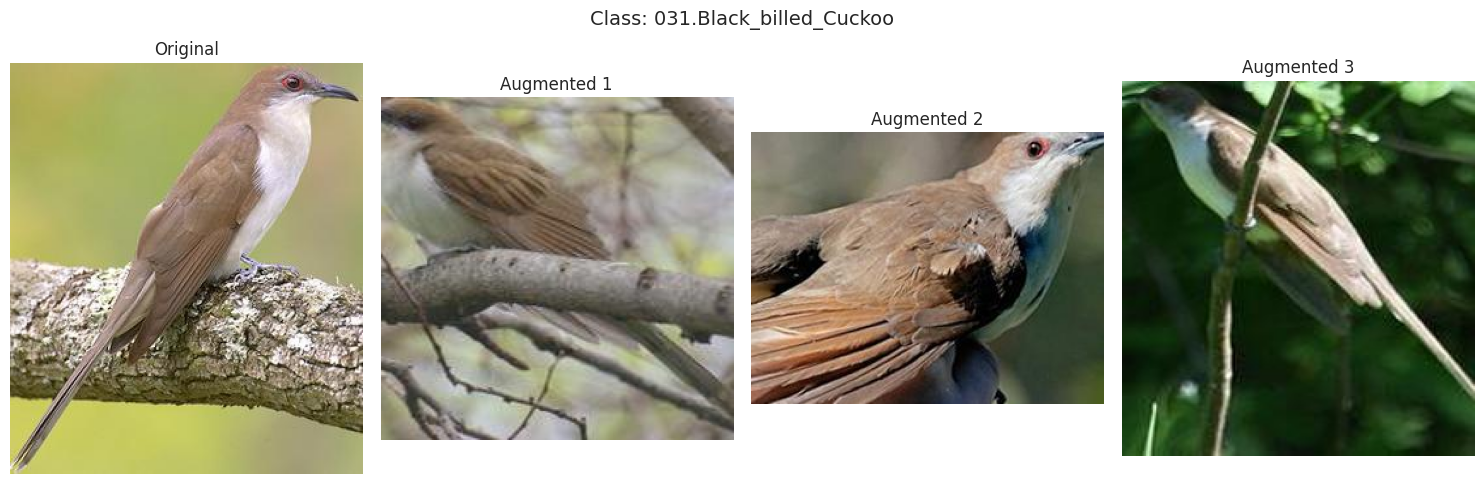

In [ ]:
# Paths
train_dir = "./datasets/cub200_cropped/train_cropped/"
aug_dir = "./datasets/cub200_cropped/train_cropped_augmented/"

# Pick a random class
classes = sorted(os.listdir(train_dir))
cls = random.choice(classes)

# Pick a random original image from that class
orig_images = [f for f in os.listdir(os.path.join(train_dir, cls)) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
orig_img_name = random.choice(orig_images)
orig_img_path = os.path.join(train_dir, cls, orig_img_name)

# Get augmented images corresponding to the same class
aug_images = [f for f in os.listdir(os.path.join(aug_dir, cls)) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
sample_aug_imgs = random.sample(aug_images, min(3, len(aug_images)))  # show up to 3 augmentations

# Show original + augmented
fig, axes = plt.subplots(1, len(sample_aug_imgs) + 1, figsize=(15, 5))

# Original image
axes[0].imshow(Image.open(orig_img_path))
axes[0].axis("off")
axes[0].set_title("Original")

# Augmented images
for i, aug_img in enumerate(sample_aug_imgs, start=1):
    aug_img_path = os.path.join(aug_dir, cls, aug_img)
    axes[i].imshow(Image.open(aug_img_path))
    axes[i].axis("off")
    axes[i].set_title(f"Augmented {i}")

plt.suptitle(f"Class: {cls}", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
!pip install Augmentor --quiet

!python img_aug.py

Initialised with 0 image(s) found.
Output directory set to ./datasets/cub200_cropped/train_cropped/111.Loggerhead_Shrike/./datasets/cub200_cropped/train_cropped_augmented/111.Loggerhead_Shrike.Traceback (most recent call last):
  File "/content/ProtoPNet/img_aug.py", line 26, in <module>
    p.process()
  File "/usr/local/lib/python3.12/dist-packages/Augmentor/Pipeline.py", line 391, in process
    self.sample(0, multi_threaded=True)
  File "/usr/local/lib/python3.12/dist-packages/Augmentor/Pipeline.py", line 348, in sample
    raise IndexError("There are no images in the pipeline. "
IndexError: There are no images in the pipeline. Add a directory using add_directory(), pointing it to a directory containing images.


## **Exploratory Data Analysis**

The dataset uses an almost balanced split, with 5,994 images in the training set and 5,794 images in the testing set, which corresponds roughly to a 50/50 ratio. Unlike many modern datasets that favor an 80/20 or 70/30 split, CUB-200-2011 was designed for fine-grained classification, where evaluation should be equally challenging. On average, each class has around 30 training and 30 testing images, although minor variations exist due to differences in the total number of available images per species. For example, some classes, such as Crested Auklet, contain only 14 test images, while others are perfectly balanced. This balanced design ensures that the model’s performance is tested under more challenging conditions, with limited data per class and an equally large evaluation set.

### Dataset Overview & Image Counts

In [ ]:
def count_images_per_class(directory):
    """Count number of images in each class folder."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count images per class
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

print("=== Dataset Overview ===")
print(f" • Total classes          : {len(train_counts)}")
print(f" • Total training images  : {sum(train_counts.values())}")
print(f" • Total testing images   : {sum(test_counts.values())}")

# Show a few example classes
print("\n=== Example Class Distribution ===")
for i, (cls, count) in enumerate(list(train_counts.items())[:5]):
    print(f" • {cls}: {count} training images, {test_counts.get(cls, 0)} testing images")

=== Dataset Overview ===
 • Total classes          : 10
 • Total training images  : 300
 • Total testing images   : 300

=== Example Class Distribution ===
 • 010.Red_winged_Blackbird: 30 training images, 30 testing images
 • 029.American_Crow: 30 training images, 30 testing images
 • 031.Black_billed_Cuckoo: 30 training images, 30 testing images
 • 057.Rose_breasted_Grosbeak: 30 training images, 30 testing images
 • 104.American_Pipit: 30 training images, 30 testing images


### Check for Missing Classes in Train/Test Splits

In [ ]:
missing_in_test = set(train_counts.keys()) - set(test_counts.keys())
missing_in_train = set(test_counts.keys()) - set(train_counts.keys())

if missing_in_test:
    print(f"Classes missing in test set: {len(missing_in_test)}")
else:
    print("No classes are missing in the test set.")

if missing_in_train:
    print(f"Classes missing in train set: {len(missing_in_train)}")
else:
    print("No classes are missing in the train set.")

No classes are missing in the test set.
No classes are missing in the train set.


In [ ]:
# Convert counts into DataFrames
train_df = pd.DataFrame.from_dict(train_counts, orient="index", columns=["train_images"])
test_df = pd.DataFrame.from_dict(test_counts, orient="index", columns=["test_images"])

# Merge them into one table
counts_df = train_df.join(test_df, how="outer").fillna(0).astype(int)
counts_df["total_images"] = counts_df["train_images"] + counts_df["test_images"]

print("\n=== Combined Class Counts ===")
print(counts_df.head())


=== Combined Class Counts ===
                            train_images  test_images  total_images
010.Red_winged_Blackbird              30           30            60
029.American_Crow                     30           30            60
031.Black_billed_Cuckoo               30           30            60
057.Rose_breasted_Grosbeak            30           30            60
104.American_Pipit                    30           30            60


In [ ]:
def check_corrupted_images(root_dir):
    corrupted_files = []
    total_images = 0

    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            total_images += 1
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity without fully loading
            except Exception:
                corrupted_files.append(img_path)

    return corrupted_files, total_images


# Check train set
corrupted_train, total_train = check_corrupted_images(train_dir)
print(f"Train set: {total_train} images scanned.")
print(f"Corrupted or unreadable images in train set: {len(corrupted_train)}")
if corrupted_train:
    print("\nExample corrupted train images:")
    print("\n".join(corrupted_train[:5]))

# Check test set
corrupted_test, total_test = check_corrupted_images(test_dir)
print(f"\nTest set: {total_test} images scanned.")
print(f"Corrupted or unreadable images in test set: {len(corrupted_test)}")
if corrupted_test:
    print("\nExample corrupted test images:")
    print("\n".join(corrupted_test[:5]))

Train set: 300 images scanned.
Corrupted or unreadable images in train set: 0

Test set: 300 images scanned.
Corrupted or unreadable images in test set: 0


### Visualize Class Distribution

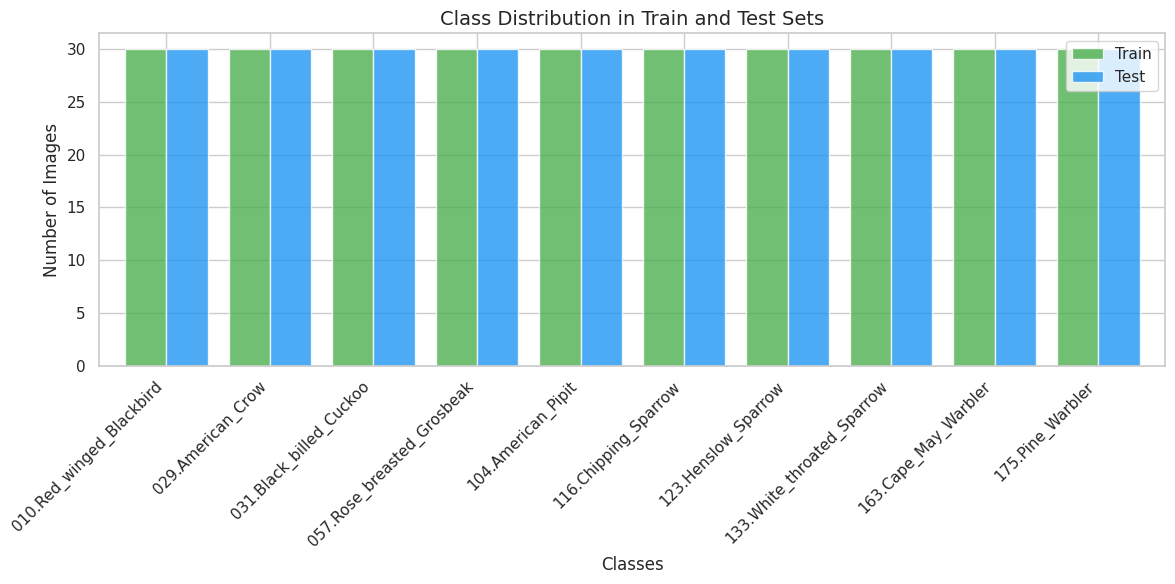

In [ ]:
# Plot class distribution for the remaining 10 classes
ax = counts_df[["train_images", "test_images"]].plot(
    kind="bar",
    figsize=(12, 6),
    color=["#4CAF50", "#2196F3"],
    alpha=0.8,
    width=0.8
)

# Title and labels
plt.title("Class Distribution in Train and Test Sets", fontsize=14)
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.xticks(rotation=45, ha="right")

# Add legend
plt.legend(["Train", "Test"])

# Optimize layout
plt.tight_layout()
plt.show()

### Analyze image dimensions (width & height)

In [ ]:
def get_image_sizes(root_dir, num_samples=300):
    """Randomly sample images and record their dimensions."""
    sizes = []
    all_images = []

    # Collect all image paths
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                all_images.append(os.path.join(class_path, img_file))

    # Random sampling
    sample_images = random.sample(all_images, min(len(all_images), num_samples))

    # Record image sizes
    for img_path in sample_images:
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)  # (width, height)
        except:
            # Skip unreadable or corrupted images
            continue

    return pd.DataFrame(sizes, columns=["width", "height"])

# Run the function on your train directory
image_sizes_df = get_image_sizes(train_dir, num_samples=2000)

In [ ]:
# Basic descriptive statistics
print("=== Image Dimensions Summary ===")
print(image_sizes_df.describe().to_string())

=== Image Dimensions Summary ===
            width     height
count  300.000000  300.00000
mean   263.793333  233.47000
std     87.745474   77.91829
min    100.000000  100.00000
25%    198.250000  178.75000
50%    256.000000  226.00000
75%    329.000000  277.00000
max    478.000000  474.00000


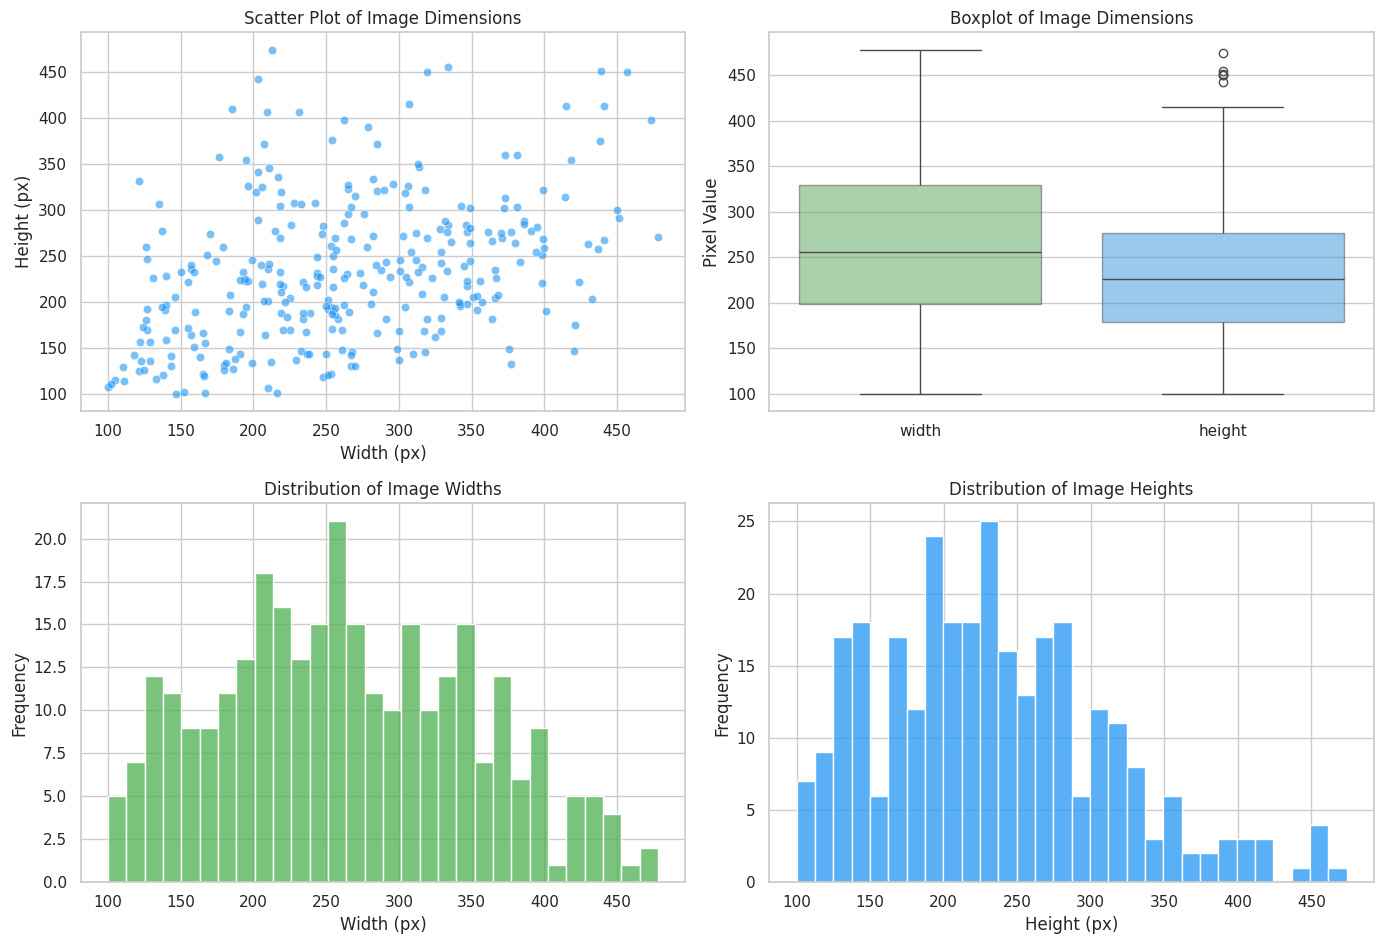

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot: width vs height (top-left)
sns.scatterplot(
    data=image_sizes_df, x="width", y="height",
    alpha=0.6, color="#2196F3", ax=axes[0, 0]
)
axes[0, 0].set_title("Scatter Plot of Image Dimensions")
axes[0, 0].set_xlabel("Width (px)")
axes[0, 0].set_ylabel("Height (px)")

# 2. Boxplot for outliers (top-right) with transparency
sns.boxplot(
    data=image_sizes_df[["width", "height"]],
    palette=["#4CAF50", "#2196F3"],
    ax=axes[0, 1],
    boxprops=dict(alpha=0.5)   # transparency for boxes
)
axes[0, 1].set_title("Boxplot of Image Dimensions")
axes[0, 1].set_ylabel("Pixel Value")

# 3. Histogram of widths (bottom-left)
sns.histplot(
    image_sizes_df["width"], bins=30,
    color="#4CAF50", ax=axes[1, 0]
)
axes[1, 0].set_title("Distribution of Image Widths")
axes[1, 0].set_xlabel("Width (px)")
axes[1, 0].set_ylabel("Frequency")

# 4. Histogram of heights (bottom-right)
sns.histplot(
    image_sizes_df["height"], bins=30,
    color="#2196F3", ax=axes[1, 1]
)
axes[1, 1].set_title("Distribution of Image Heights")
axes[1, 1].set_xlabel("Height (px)")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Display random sample images from random classes

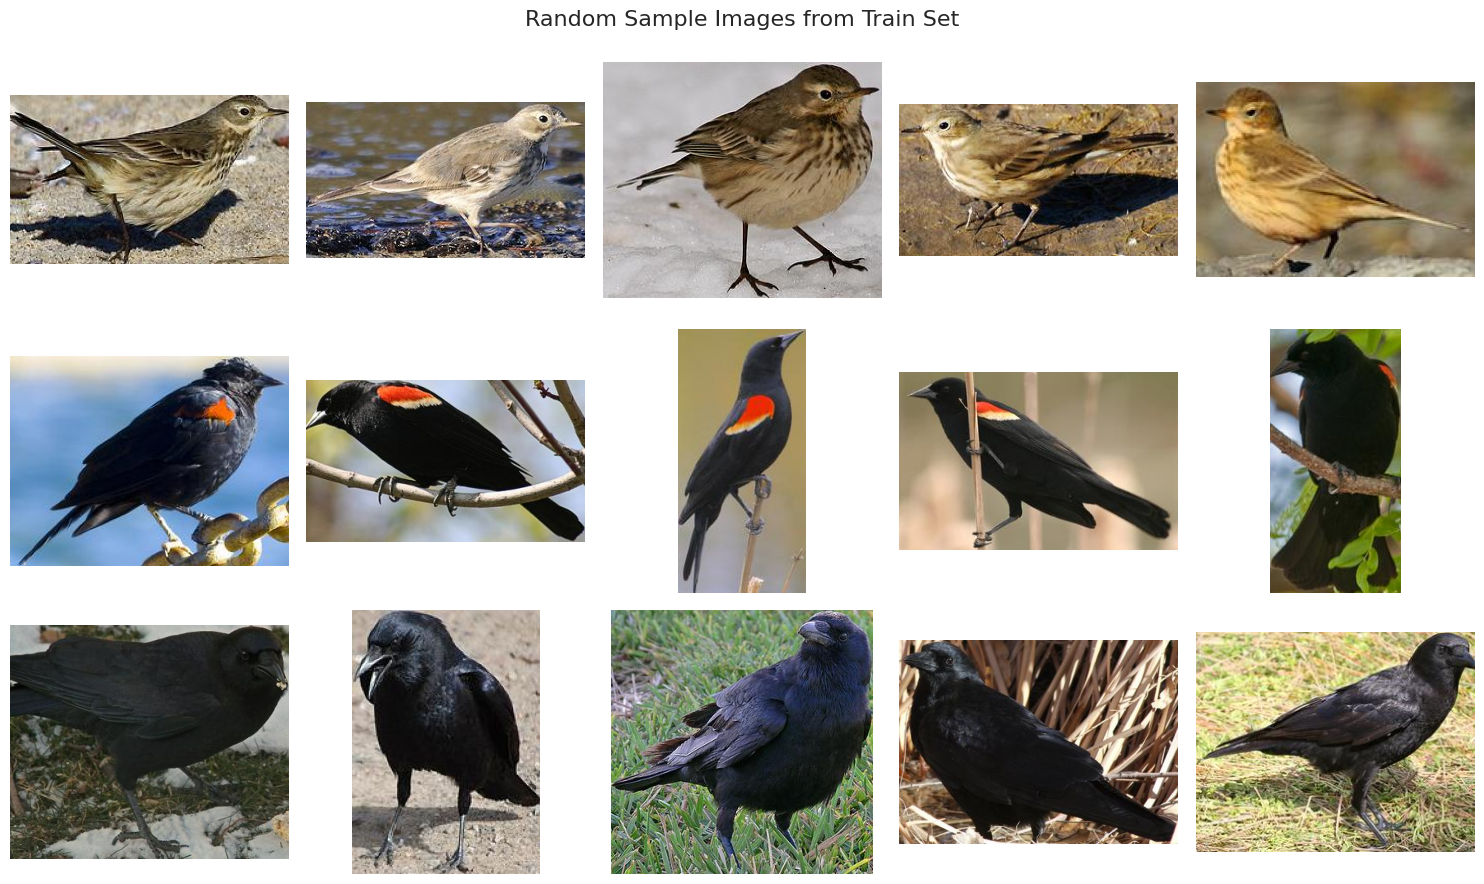

In [ ]:
def show_random_images(root_dir, num_classes=3, num_images=5):
    """Display a grid of random images from random classes."""
    # Pick random classes
    class_names = random.sample(sorted(os.listdir(root_dir)), num_classes)
    plt.figure(figsize=(num_images * 3, num_classes * 3))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(root_dir, class_name)
        image_files = os.listdir(class_path)

        # Pick random images for each class
        images = random.sample(image_files, min(len(image_files), num_images))

        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)

            # Open and display image
            img = Image.open(img_path)
            plt.subplot(num_classes, num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis("off")

            # Label class name on the left of the row
            if j == 0:
                plt.ylabel(class_name, fontsize=12, rotation=0, labelpad=40)

    plt.suptitle("Random Sample Images from Train Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 3 random classes with 5 random images each
show_random_images(train_dir, num_classes=3, num_images=5)

# Simple Model

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [ ]:
# Dataset paths
train_dir = "./datasets/cub200_cropped/train_cropped_augmented"
test_dir = "./datasets/cub200_cropped/test_cropped"

# Image transforms (matching pretrained ResNet input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load train and test datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train size: 9000, Test size: 300
Classes: ['010.Red_winged_Blackbird', '029.American_Crow', '031.Black_billed_Cuckoo', '057.Rose_breasted_Grosbeak', '104.American_Pipit', '116.Chipping_Sparrow', '123.Henslow_Sparrow', '133.White_throated_Sparrow', '163.Cape_May_Warbler', '175.Pine_Warbler']


In [ ]:
# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)
resnet.eval()  # freeze model

# Remove the classification head — keep only feature extractor
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to("cuda" if torch.cuda.is_available() else "cpu")

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [ ]:
def extract_features(dataloader):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = feature_extractor(images)       # shape: (batch, 2048, 1, 1)
            features = features.view(features.size(0), -1)  # flatten to (batch, 2048)

            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract embeddings
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

print("Feature shape:", train_features.shape)

Feature shape: (9000, 2048)


In [ ]:
clf = LogisticRegression(max_iter=500, solver="lbfgs", multi_class="multinomial")
clf.fit(train_features, train_labels)

# Predict on test set
y_pred = clf.predict(test_features)

# Evaluate
print("Accuracy:", accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred, target_names=train_dataset.classes))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9466666666666667
                            precision    recall  f1-score   support

  010.Red_winged_Blackbird       1.00      0.90      0.95        30
         029.American_Crow       0.94      1.00      0.97        30
   031.Black_billed_Cuckoo       1.00      1.00      1.00        30
057.Rose_breasted_Grosbeak       1.00      1.00      1.00        30
        104.American_Pipit       0.97      0.93      0.95        30
      116.Chipping_Sparrow       0.87      0.90      0.89        30
       123.Henslow_Sparrow       0.88      0.93      0.90        30
133.White_throated_Sparrow       0.89      0.83      0.86        30
      163.Cape_May_Warbler       0.97      0.97      0.97        30
          175.Pine_Warbler       0.97      1.00      0.98        30

                  accuracy                           0.95       300
                 macro avg       0.95      0.95      0.95       300
              weighted avg       0.95      0.95      0.95       300



...